# Allowed libraries
- Tensorflow (compatible with 1.12.x)
- Numpy
- Sklearn
- nltk
- Maplotlib
- gensim
- All the standard libraries
 

https://medium.com/the-artificial-impostor/nlp-four-ways-to-tokenize-chinese-documents-f349eb6ba3c3

https://stanfordnlp.github.io/CoreNLP/download.html

In [53]:

# from google.colab import drive

# drive.mount('/content/gdrive')


# %cd gdrive/My\ Drive/Chinese-LSTM/code

In [55]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

from typing import Tuple, List, Dict
import tensorflow.keras as K
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from sklearn.preprocessing import OneHotEncoder

plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [ ]:
from tensorflow.random import set_random_seed
set_random_seed(42)

In [3]:
def ChooseDataset(set_type, subset):
    '''returns paths to Label and Input file for a specific dataset
    args: set_type
    return: Label_file, Input_file
    '''
    datasets = {"training":'../icwb2-data/training',
                "dev":'../icwb2-data/gold',
                "testing":'../icwb2-data/testing'}

    def get_file_names(path, type_='LabelFile'):
        x = []
        dev = True if path.split("/")[-1] == 'gold' else False #checks for dev
        for i in os.listdir(path):
            if dev and i.split("_")[1][:4]=='test': #eliminates 'training' from 'gold'
                if os.path.splitext(i)[0].split("_")[-1] == type_:
                    x.append(os.path.join(path, i))
            elif not dev:
                if os.path.splitext(i)[0].split("_")[-1] == type_:
                    x.append(os.path.join(path, i))
        return x

    Label_files = get_file_names(path = datasets[set_type], type_ = 'LabelFile')
    Input_files = get_file_names(path = datasets[set_type], type_ = 'InputFile')
    names = ['msr','cityu','as','pku']
    choose = lambda i: i.split(".utf8")[0].split('/')[-1].split("_")[0]
    e, r = False, False
    chosen = False
    while not chosen:
        #x = input("Choose from the following: {}".format(names))
        x = subset
        for i in range(len(Label_files)):
            if choose(Input_files[i]) == x:
                Input_file = Input_files[i]
                e = True
            if choose(Label_files[i]) == x:
                Label_file = Label_files[i]
                r = True
            if e and r:
                chosen = True

    return Label_file, Input_file

In [4]:
class CreateDataset(object):
    '''makes feed files of combined unigrams and bigrams'''
    def __init__(self, LabelFile_path, InputFile_path, PaddingSize, set_type, TrainingVocab):
        self.Label_File = LabelFile_path
        self.Input_File = InputFile_path
        self.PaddingSize = PaddingSize
        self.set_type = set_type
        self.TrainingVocab = TrainingVocab
    
    def DateGen(self):
        '''Data generator given the feature generator. Pads the feature vectors accordingly
        returns: X_unigrams, X_bigrams, y, info (includes padding size, vocab sizes),
        uni_word_to_idx, bi_word_to_idx
        '''
        
        uni_feature_vectors, bi_feature_vectors, uni_word_to_idx, bi_word_to_idx = self.FeatureGenerator() 
        
        labels = self.BIESToNumerical()
        
        padded_labels = pad_sequences(labels, truncating='pre', padding='post', maxlen = self.PaddingSize)
        y =  K.utils.to_categorical(padded_labels, num_classes=4)
        
        X_unigrams = pad_sequences(uni_feature_vectors, truncating='pre',
                                   padding='post', maxlen = self.PaddingSize)
        X_bigrams = pad_sequences(bi_feature_vectors, truncating='pre',
                                  padding='post', maxlen = self.PaddingSize)
        
        info = {"uni_VocabSize": len(uni_word_to_idx),
                "bi_VocabSize": len(bi_word_to_idx)}
        return X_unigrams, X_bigrams, y, info, uni_word_to_idx, bi_word_to_idx
    
    def BIESToNumerical(self):
        '''Converts Label File from BIES encoding to numerical classes'''
        BIES = {'B' : 0, 'I' : 1, 'E' : 2, 'S' : 3}
        #numerical BIES class given to a line 
        labels = []
        with open(self.Label_File, 'r', encoding ='utf8') as f1:
            count = 0
            for line in f1:
                l = line.rstrip()
                labels.append([BIES[i] for i in l])
        return labels
    
    def FeatureGenerator(self):
        '''Generates features based on unigrams and bigrams going line by line
        returns: unigram_feature_vectors, bigram_feature_vectors
        if training then returns also the word_to_idx for both unigrams and bigrams
        '''
        
        uni_feature_vectors, bi_feature_vectors = [], []
        
        if self.set_type == 'training':
            uni_word_to_idx, bi_word_to_idx = self.generateVocab()
        else:
            uni_word_to_idx, bi_word_to_idx = self.TrainingVocab

        with open(self.Input_File, 'r', encoding ='utf8') as f1:
            for line in f1:
                line = line.rstrip()
                
                unigrams = self.split_into_grams(line, 'uni_grams')
                bigrams = self.split_into_grams(line,'bi_grams')
                
                uni_feature_vectors.append([uni_word_to_idx.get(i, 0) for i in unigrams])
                bi_feature_vectors.append([bi_word_to_idx.get(i, 0) for i in bigrams])
                
        return uni_feature_vectors, bi_feature_vectors, uni_word_to_idx, bi_word_to_idx
    
    def generateVocab(self):
        '''
        Generates vocabulary based on file
        args: Inputfile, returns: word_to_index for unigrams and bigrams seperetly 
        '''
        with open(self.Input_File, 'r', encoding ='utf8') as f1:
            lines = f1.readlines()
            raw = ' '.join(' '.join(lines).split()) #one long string
        #creating unigrams and bigrams
        unigrams, bigrams = self.split_into_grams(raw, 'uni_grams'), self.split_into_grams(raw, 'bi_grams')
        del raw #erase from memory
        #geting seperate vocavularies
        unigrams_vocab, bigrams_vocab = set(unigrams), set(bigrams) 

        #initializing sepeate dictionaries
        uni_word_to_idx, bi_word_to_idx = dict(), dict()
        #Handling OOV
        uni_word_to_idx["<UNK>"], bi_word_to_idx["<UNK>"] = 0, 0
        #creating the rest of the word to index dict
        uni_word_to_idx.update({value:key+1 for key,value in enumerate(unigrams_vocab)})
        bi_word_to_idx.update({value:key+1 for key,value in enumerate(bigrams_vocab)})

        return uni_word_to_idx, bi_word_to_idx
        
    
    @staticmethod
    def split_into_grams(sentence: str, type_ = 'uni_grams') -> List[str]:
        """
        :param sentence Sentence as str
        :type_: uni_grams or _bigrams
        :return bigrams List of unigrams or bigrams
        """
        n = 1 if type_ == 'uni_grams' else 2
        grams = []
        for i in range(len(sentence)-1):
            gram = sentence[i:i+n]
            grams.append(gram)
        return grams

    

In [5]:
def data_feed(subset='pku',padding=50):
    '''function that creates a dataset -- training, dev, and test
    args: subset: any subset, padding: padding size
    returns: (X_train, y_train), (X_dev, y_dev), (X_test, y_test), info_dev
    '''
    
    type_ = "training"
    print("*****{}*****".format(type_))
    Label_file, Input_file = ChooseDataset(type_, subset)
    A = CreateDataset(Label_file, Input_file, padding, type_, None)
    X_train_uni, X_train_bi, y_train, info_train, uni_word_to_idx, bi_word_to_idx = A.DateGen()
    print("X uni-bi shape: {}{}\ny shape: {}".format(X_train_uni.shape, X_train_bi.shape, y_train.shape))
    print(info_train)
    
    type_ = 'dev'
    Label_file, Input_file = ChooseDataset(type_, subset)
    print(Label_file, Input_file)
    A = CreateDataset(Label_file, Input_file, padding, type_, [uni_word_to_idx, bi_word_to_idx])
    X_dev_uni, X_dev_bi, y_dev, info_dev, _, _ = A.DateGen()
    print("*****{}*****".format(type_))
    print("X uni-bi shape: {}{}\ny shape: {}".format(X_dev_uni.shape, X_dev_bi.shape, y_train.shape))
    print(info_dev)
    
    type_ = 'testing'
    Label_file, Input_file = ChooseDataset(type_, subset)
    A = CreateDataset(Label_file, Input_file, padding, type_, [uni_word_to_idx, bi_word_to_idx])
    X_test_uni, X_test_bi, y_test, info_test, _, _ = A.DateGen()
    print("*****{}*****".format(type_))
    print("X uni-bi shape: {}{}\ny shape: {}".format(X_test_uni.shape, X_test_bi.shape, y_train.shape))
    print(info_test)
    
    return {"train": {"X": [X_train_uni, X_train_bi],
                      "y": y_train}, 
           "dev": {"X": [X_dev_uni, X_dev_bi],
                   "y": y_dev},
           "test": {"X": [X_test_uni, X_test_bi],
                    "y": y_test},
           "info": info_train}



In [6]:
SUBSET = 'pku'
PADDING_SIZE = 10
data = data_feed(SUBSET, PADDING_SIZE)

*****training*****
X uni-bi shape: (19056, 10)(19056, 10)
y shape: (19056, 10, 4)
{'uni_VocabSize': 4692, 'bi_VocabSize': 279845}
../icwb2-data/gold/pku_test_gold_simplified_LabelFile.utf8 ../icwb2-data/gold/pku_test_gold_simplified_InputFile.utf8
*****dev*****
X uni-bi shape: (1945, 10)(1945, 10)
y shape: (19056, 10, 4)
{'uni_VocabSize': 4692, 'bi_VocabSize': 279845}
*****testing*****
X uni-bi shape: (1945, 10)(1945, 10)
y shape: (19056, 10, 4)
{'uni_VocabSize': 4692, 'bi_VocabSize': 279845}


# model

In [7]:
VOCAB_SIZE = {"unigrams": data['info']['uni_VocabSize'],
              "bigrams": data['info']['bi_VocabSize']}
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 256
batch_size = 128
epochs = 5

In [8]:
K.backend.clear_session()

In [9]:
model_name = time.strftime('%Y-%m-%d_%H:%M:%S_%z')
def create_keras_model(vocab_size, embedding_size, hidden_size, PADDING_SIZE):
    print("Creating KERAS model")
    
    unigrams = K.layers.Input(shape=(PADDING_SIZE,),name = 'unigrams')
    embedding_unigrams = K.layers.Embedding(vocab_size["unigrams"], embedding_size,
                                            mask_zero=True, name = 'embedding_unigrams')(unigrams)
    
    bigrams = K.layers.Input(shape=(PADDING_SIZE,),name = 'bigrams')
    embedding_bigrams = K.layers.Embedding(vocab_size["bigrams"], embedding_size,
                                           mask_zero=True, name = 'embedding_bigrams')(bigrams)

    merged_vector = K.layers.concatenate([embedding_unigrams, embedding_bigrams], axis=-1, name = 'concatenated')
    
    #two different emnedding layers
    BI_LSTM = (K.layers.Bidirectional(
               K.layers.LSTM(hidden_size, dropout=0.2, recurrent_dropout=0.,
                             return_sequences=True),name = 'Bi-directional_LSTM'))(merged_vector)
    
    predictions = K.layers.TimeDistributed(K.layers.Dense(4, activation='softmax'))(BI_LSTM)
    
    model = K.models.Model(inputs=[unigrams, bigrams], outputs=predictions)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

model = create_keras_model(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, PADDING_SIZE)
# Let's print a summary of the model
model.summary()

Creating KERAS model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unigrams (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
bigrams (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_unigrams (Embedding)  (None, 10, 32)       150144      unigrams[0][0]                   
__________________________________________________________________________________________________


In [10]:
if not os.path.exists('../resources/report_images'):
    os.mkdir('../resources/report_images')

cbk = K.callbacks.TensorBoard('../resources/logging/keras_model_'+model_name)
print("\nStarting training...")
K.utils.plot_model(model, to_file='../resources/report_images/model.png')


Starting training...


In [11]:
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
csv_logger = K.callbacks.CSVLogger('../resources/logging/keras_model_'+model_name+'.log')

In [12]:

model.fit(data["train"]["X"], data["train"]["y"],
          epochs=epochs, batch_size=batch_size, shuffle=True,
          validation_data=(data["dev"]["X"], data["dev"]["y"]),
          callbacks=[cbk, csv_logger, early_stopping]) 

print("Training complete.\n")



Train on 19056 samples, validate on 1945 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
19056/19056 [==============================] - 45s 2ms/sample - loss: 1.0437 - acc: 0.5702 - val_loss: 0.9914 - val_acc: 0.5725
Epoch 2/5
19056/19056 [==============================] - 42s 2ms/sample - loss: 0.8468 - acc: 0.6279 - val_loss: 0.9295 - val_acc: 0.5931
Epoch 3/5
19056/19056 [==============================] - 43s 2ms/sample - loss: 0.6111 - acc: 0.7526 - val_loss: 0.9494 - val_acc: 0.6181
Epoch 4/5
19056/19056 [==============================] - 42s 2ms/sample - loss: 0.3906 - acc: 0.8547 - val_loss: 1.1024 - val_acc: 0.6229
Training complete.



In [13]:
if not os.path.exists('../resources/models'):
    os.mkdir('../resources/models')
rel_path = '../resources/models'
weights = os.path.join(rel_path,'model_weights_'+model_name+'.h5')
model_name_save = os.path.join(rel_path,'model_'+model_name+'.h5')
model.save_weights(weights) #saving weights for further analysis
model.save(model_name_save)

In [14]:
print("\nEvaluating test...")
loss_acc = model.evaluate(data["test"]["X"], data["test"]["y"], verbose=3)
print("Test data: loss = %0.6f  accuracy = %0.2f%% " % (loss_acc[0], loss_acc[1]*100))


Evaluating test...
Test data: loss = 7.112935  accuracy = 4.03% 


In [15]:
#!tensorboard --logdir logging

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


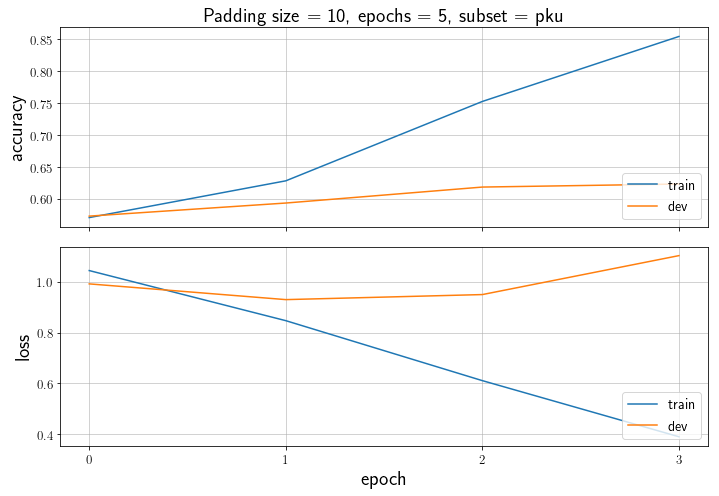

In [56]:
def plot_training(model_name, save = False, PADDING_SIZE = None, epochs = None, subset = None, size = 30):
    if not model_name:
        selected = False
        while not selected:
            c=0
            for ind, i in enumerate(os.listdir("../resources/logging")):
                print("{}:\t{}".format(ind, i))
            x = int(input("Please select one of the above with a numer: "))
            model_name = os.listdir("../resources/logging")[x]
            if model_name.endswith(".log"):
                selected = True
            else: 
                print("please select a correct log file to load")
        history = pd.read_csv('../resources/logging/'+model_name)
        PADDING_SIZE, epochs, subset = 'Unknown', history.shape[0], 'Unknown'
    else:
        history = pd.read_csv('../resources/logging/keras_model_'+model_name+'.log')
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7))
    # summarize history for accuracy
    axs[0].plot(history['acc'])
    axs[0].plot(history['val_acc'])
    #axs[0].title('model accuracy')
    axs[0].set_ylabel('accuracy',size = size)
    #axs[0].set_xlabel('epoch')
    axs[0].set_xticks((list(range(0,epochs))))
    axs[0].legend(['train', 'dev'], loc='lower right')
    axs[0].grid(alpha=0.7)

    axs[0].set_title("Padding size = {}, epochs = {}, subset = {}".format(PADDING_SIZE, epochs, subset), size = size)
    
    axs[0].tick_params(axis='x', labelsize=int(size/1.5))
    axs[1].tick_params(axis='x', labelsize=int(size/1.5))
    axs[0].tick_params(axis='y', labelsize=int(size/1.5))
    axs[1].tick_params(axis='y', labelsize=int(size/1.5))
    
    # summarize history for loss
    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].set_ylabel('loss', size = size)
    axs[1].set_xlabel('epoch', size = size)
    axs[1].set_xticks((list(range(0,epochs-1))))
    axs[1].legend(['train', 'dev'], loc='lower right')
    axs[1].grid(alpha=0.7)
    fig.show()
    fig.tight_layout()
    fig.subplots_adjust(wspace=1, hspace=0.1)
    if save:
        fig.savefig("../resources/report_images/"+model_name+"training_plot.png")
plot_training(model_name, True, PADDING_SIZE, epochs, SUBSET, size = 20)